# Imports

In [1]:
from itertools import islice
from itertools import combinations
from functools import partial
from multiprocess import Pool
from time import perf_counter, gmtime, strftime

In [2]:
import numpy as np
import pandas as pd
import numpy.linalg as la
import matplotlib.pyplot as plt

from scipy.spatial import ConvexHull
from scipy.spatial import convex_hull_plot_2d

from scipy.stats import multivariate_normal
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import bernoulli
from scipy.stats import gaussian_kde
from scipy.stats import gmean
import pingouin as pg # Henze-Zikler test of multivariate normality

# Functions

In [3]:
def get_hull(points: np.array):

    hull = ConvexHull(points,qhull_options='QJ')
    vertices = points[hull.vertices,:]
    simplices = points[hull.simplices,:]
    
    return hull, vertices, simplices

In [4]:
def distance_to_simplex(x, simplex: np.array, tol: float=1e-8):
    
    d = simplex.shape[1]
    precision = max([int(abs(np.log10(tol)))-1,0])
    
    xflat = x.flatten()
    
    shift = np.ones(d)*tol
    nhat = normal(simplex+shift,d)
    dist = np.abs(np.atleast_2d(nhat)@(xflat-(simplex+shift)[0]).T)

    return np.around(dist,precision)[0]

In [5]:
def center_transform_coeffs(vertices: np.array, simplices: np.array):
    
    cm = np.average(vertices,axis=0)[None,:] # center of mass
    r = min([distance_to_simplex(cm,simplex) for simplex in simplices])
    ratio = min([r,1])
    
    return cm, ratio

In [6]:
def distance_to_simplex(x, simplex: np.array, tol: float=1e-8):
    
    d = simplex.shape[1]
    precision = max([int(abs(np.log10(tol)))-1,0])
    
    xflat = x.flatten()
    
    shift = np.ones(d)*tol # perturb a bit to aviod numerical issues
    nhat = normal(simplex+shift,d)
    dist = np.abs(np.atleast_2d(nhat)@(xflat-(simplex+shift)[0]).T)

    return np.around(dist,precision)[0]

In [7]:
def scale(x: np.array, points: np.array, normals: np.array):
    
    shifts = x.flatten() - points
    dists = [abs(normal @ shift.T) for normal, shift in zip(normals, shifts)]
    r = min(dists)
    
    return min([r,1])

In [8]:
def box_yield():
    while True:
        yield np.random.uniform(box_lows,box_highs,(1,d))

In [9]:
def outside_ball(x):
    
    return x @ x.T >= 1

In [10]:
def box_sample(box_lows, box_highs, d, N: int=1):
    
    return np.random.uniform(box_lows,box_highs,(N,d))

In [11]:
def ball_sample(N: int=1, R: float=1.):
    
    us = np.random.normal(size=(N,d))
    norms = la.norm(us,axis=1)[:,None]
    rs = R*np.power(np.random.uniform(size=N),1/d)[:,None]
    
    return rs * (us/norms) 

In [12]:
def sphere_sample(N: int=1, r: float=1.):
    
    us = np.random.normal(size=(N,d))
    norms = la.norm(us,axis=1)[:,None]
    
    return r * (us/norms) 

In [13]:
def normal(simplex: np.array, dim: int):
    
    n = la.solve(simplex,np.ones(dim))
    
    return n/np.sqrt(n@n.T)

In [14]:
# 10 times slower
def normal_other(simplex: np.array, dim: int):

    n = np.array([(-1)**i*la.det(np.delete(simplex[:-1,:] - simplex[-1,:],i,axis=1)) for i in range(dim)])

    return n/np.sqrt(n@n.T)

In [15]:
def warm_yield(origin: np.array, sigma_sq: float):
    
    d = origin.shape[-1]
    
    while True:
        
        yield multivariate_normal(mean=origin.flatten(), cov=sigma_sq*np.eye(d)).rvs()

In [16]:
def warm_start(origin: np.array, hull_equations: np.array, sigma_sq: float, N: int=1):
            
    return np.array(list(islice(filter(lambda x: support(x[None,:],hull_equations)[0],
                                       warm_yield(origin,sigma_sq)),N)))

In [17]:
def distance_to_simplex(x, simplex: np.array, tol: float=1e-8):
    
    d = simplex.shape[1]
    precision = max([int(abs(np.log10(tol)))-1,0])
    
    xflat = x.flatten()
    
    shift = np.ones(d)*tol
    nhat = normal(simplex+shift,d)
    dist = np.abs(np.atleast_2d(nhat)@(xflat-(simplex+shift)[0]).T)

    return np.around(dist,precision)[0]

In [18]:
def ball_walk(f, steps, x_init, delta, is_log: bool=False):
    
    x = x_init
    xs = []
    
    for i in range(steps):
        
        y = x + ball_sample(R=delta)
        
        fy, fx = f(y), f(x)
        
        if is_log: print(f'x={x}, f(x)={fx}, y={y}, f(y)={fy}')

        alpha = min(1,f(y)/f(x))
        
        x = y if bernoulli.rvs(alpha) else x
        
        xs.append(x)
        
    return xs

In [19]:
from typing import Optional

def support(xs, hull_equations: np.array, R: Optional[float]=None, tol: float=1e-8):
    
    N = xs.shape[0]
    multi = hull_equations @ np.vstack([xs.T,np.ones(N)[None,:]])
    multi = np.where(np.isclose(multi,0,atol=tol),0,multi)
    
    inside = np.all(multi <= 0, axis=0) * (la.norm(xs,axis=1) <= R) if R else np.all(multi <= 0, axis=0)
    
    return inside 

In [20]:
# projection of point onto chord between x1 and x2

def projection(x, x1, x2, tol: float=1e-8):
    
    nhat = (x2-x1)/np.sqrt((x2-x1)@(x2-x1).T)
    
    return x1 + ((x-x1)@nhat.T)*nhat

In [21]:
# this assumes x is inside hull !!!

def chord_intersection_points(x: np.array, ray: np.array, simplices: np.array, normals: np.array):
    
    ts = [nhat@(simplex[0]-x).T / np.dot(nhat,ray.flatten()) for nhat, simplex in zip(normals, simplices)]

    ts_minus = [t if t<0 else -np.inf for t in ts]
    ts_plus = [t if t>0 else np.inf for t in ts]

    x_minus = ts[np.argmax(np.array(ts_minus))]*ray+x
    x_plus = ts[np.argmin(np.array(ts_plus))]*ray+x
    
    return x_minus, x_plus

In [22]:
# this assumes x is inside hull !!!

def chord_intersection(x: np.array, ray: np.array, hull_equations: np.array):
    
    pos_mask = hull_equations[:,:-1] @ ray.T >= 0
    pos_hull = hull_equations[pos_mask]
    ts_plus = ((-pos_hull[:,-1:] - (pos_hull[:,:-1]@x.T)[:,None]) / (pos_hull[:,:-1]@ray.T)[:,None]).min()

    neg_mask = hull_equations[:,:-1] @ ray.T <= 0
    neg_hull = hull_equations[neg_mask]
    ts_minus = ((-neg_hull[:,-1:] - (neg_hull[:,:-1]@x.T)[:,None]) / (neg_hull[:,:-1]@ray.T)[:,None]).max()

    x_minus = ts_minus*ray+x
    x_plus = ts_plus*ray+x
    
    return x_minus, x_plus

In [23]:
def chord_interval(mu: np.array, x1: np.array, x2: np.array):
    
    if (x2-mu)@(mu-x1).T>0: # mu between x1 and x2
        a, b = -la.norm(mu-x1), la.norm(x2-mu)
        
    elif (x2-x1)@(x1-mu).T>0: # x1 between mu and x2
        a, b = la.norm(x1-mu), la.norm(x2-mu)
        
    elif (x1-x2)@(x2-mu).T>0: # x2 between mu and x1
        a, b = -la.norm(x1-mu), -la.norm(x2-mu)
        
    else:
        a, b = None, -la.norm(x2-mu)
                    
    return a, b

In [24]:
def chord_sample(mu: np.array, x1: np.array, x2: np.array, **kwargs):    
                
    (a,b) = chord_interval(mu,x1,x2)        
    chord_length = b - a # must be positive
    chord_normal = (x2-x1)/ chord_length
        
    if 'sigma_sq' in kwargs: # sample from gaussian along chord
                
        sigma_sq = kwargs['sigma_sq']
        chord_gaussian = norm(loc=0.0, scale=np.sqrt(sigma_sq))
        
        if chord_length > 2*np.sqrt(sigma_sq):
            c = chord_gaussian.rvs()
            accept = c<=b and c>=a
            y = mu + c*chord_normal
        else:
            c = box_sample([a,0],[b,1],2).flatten()
            accept = chord_gaussian.pdf(c[0]) >= c[1]
            y = mu + c[0]*chord_normal
            
    else: # sample uniformly along chord
        
        chord_uniform = uniform(loc=a, scale=chord_length)    
        
        c = chord_uniform.rvs()
        accept = True
        y = mu + c*chord_normal
                            
    return y, accept


In [25]:
def _hit_and_run_single(origin,hull_equations,delta,kwargs):
    
    np.random.seed() # prevent sampling from same random state on different threads
    
    x = warm_start(origin,hull_equations,delta).flatten()
    
    count = 1

    while count<=T:

        ray = sphere_sample().flatten()
        x1, x2 = chord_intersection(x,ray,hull_equations)
        mu = projection(origin,x1,x2)

        try:
            if 'sigma_sq' in kwargs:                    
                y, accept = chord_sample(mu,x1,x2,sigma_sq=kwargs['sigma_sq'])
            else:
                y, accept = chord_sample(mu,x1,x2)
        except:
            continue

        if accept:
            x = y   
            count += 1
    
    return x

In [26]:
def hit_and_run(N: int,
                origin: np.array,
                hull_equations: np.array, 
                T: int=20, 
                delta: float=0.5, 
                **kwargs):

    kwarg_tuples = tuple({'sigma_sq': kwargs['sigma_sq']} for _ in range(N)) if 'sigma_sq' in kwargs else tuple({} for _ in range(N))

    with Pool(processes=num_cpus) as pool:

        res = pool.map_async(partial(_hit_and_run_single,origin,hull_equations,delta), kwarg_tuples)
        xs = res.get()

    return np.array(xs)

In [27]:
def singular(points: np.array):
    
    M = points.T
    U, S, _ = la.svd(M,full_matrices=False)

    svalmax = S[0]
    svecmax = U[:,0][:,None]
    svalmin = S[-1]    
    svecmin = U[:,-1][:,None]

    return svalmax, svecmax, svalmin, svecmin

In [28]:
def tranformation(svalmax: float, svecmax: np.array):
    
    return np.eye(d) + (1/svalmax-1) * svecmax@svecmax.T

In [29]:
def plot_polytope(hull: ConvexHull, origin: np.array=np.array([]), X: np.array=np.array([]), 
                figsize: tuple=(7,7), elevation: int=25, azimute: int=150, **kwargs):
    
    d = hull.points.shape[-1]
    plot_sample = False
    
    if X.size>0:
        assert X.shape[-1]==d, f'Dimension mismatch between samples of dimension {X.shape[-1]} and origin of dimension {d}.'
        plot_sample = True
        
    plot_origin = origin.size>0
        
    if d == 2:
        

        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot()
        convex_hull_plot_2d(hull, ax=ax)
        
        if plot_sample:
            ax.scatter(np.atleast_2d(X)[:,0],np.atleast_2d(X)[:,1],s=20,c='y',alpha=0.3,label='Xs')
            
        if plot_origin:
            ax.scatter(np.atleast_2d(origin)[:,0],np.atleast_2d(origin)[:,1],s=80,c='black',label='origin')
            
        plt.grid()
        plt.legend(loc='lower right')
        
        if 'xlims' in kwargs:
            plt.xlim(kwargs['xlims'])
        if 'ylims' in kwargs:
            plt.ylim(kwargs['ylims'])
            

    if d==3:

        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(projection='3d')
        
        points = hull.points
        simplices = points[hull.simplices,:]

        for i,s in enumerate(simplices):

            edges = [np.vstack(e) for e in combinations(s, 2)]

            for j,edge in enumerate(edges):
                if i+j==0:
                    ax.plot(edge[:,0],edge[:,1],edge[:,2],color='grey',label='polytope')
                else:
                    ax.plot(edge[:,0],edge[:,1],edge[:,2],color='grey')

        if plot_sample:
            ax.scatter(np.atleast_2d(X)[:,0],np.atleast_2d(X)[:,1],np.atleast_2d(X)[:,2],c='y',s=20,alpha=0.3,label='Xs')
        if plot_origin:
            ax.scatter(np.atleast_2d(origin)[:,0],np.atleast_2d(origin)[:,1],np.atleast_2d(origin)[:,2],color='black',s=40,label='origin')  
        ax.scatter(np.atleast_2d(points)[:,0],np.atleast_2d(points)[:,1],np.atleast_2d(points)[:,2],color='b',s=40,label='points')        

        ax.view_init(elev=elevation, azim=azimute)
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.draw()
        plt.legend()

# Global parameters

* ```tol```: tolerance to near zero.

In [30]:
tol = 1e-8

* ```num_cpus```: number of workers to parallelize sampling.

In [31]:
num_cpus = 4

# Hit & Run: Test

As a sanity check, we sample a spherical Gaussian in a large box. 

We then make sure the samples are approximately Gaussian by Goodness-of-Fit test.

### Parameters

* ```d```: polytope dimension.
* ```sigma_sq```: the variance of the spherical Gaussian restricted to the polytope.
* ```delta```: the variance of the spherical Gaussian that serves as a warm start for the random walk.
* ```N```: the number of independant samples to sample.

In [32]:
d = 2
sigma_sq = 4.0
delta = 0.2
N = 1000

### Box

Validate by sampling in a box.

In [33]:
points = np.array([[-10.,-10.],[-10.,10.],[10.,-10.],[10.,10.]])
hull, vertices, simplices = get_hull(points)
origin = np.average(vertices,axis=0)[None,:]

### Code

This is the base code for the Hit & Run algorithm to sample spherical Gaussian samples restricted to a polytope. It requires an additional parameter:

* ```T```: the mixing time to get a single independant sample.

In [34]:
T = 20 # mixing time

In [35]:
xs = []
results = []
chord_gaussian = norm(loc=0.0, scale=sigma_sq**(0.5))    
# normals = [normal(simplex,d) for simplex in simplices]  

for j in range(N):

    x = warm_start(origin,hull.equations,delta).flatten()
    i, count = 0, 1

    while count<=T:
        
        accept_gaussian, accept_uniform = False, False

        ray = sphere_sample().flatten()
        x1, x2 = chord_intersection(x,ray,hull.equations) # chord_intersection_points(x,ray,simplices,normals)

        try:
            chord_length = np.sqrt((x2-x1)@(x2-x1).T)
            chord_normal = (x2-x1)/ chord_length
            mu = projection(origin,x1,x2)

            if (x2-mu)@(mu-x1).T>0: # mu between x1 and x2
                a, b = -la.norm(mu-x1), la.norm(x2-mu)
            if (x2-x1)@(x1-mu).T>0: # x1 between mu and x2
                a, b = la.norm(x1-mu), la.norm(x2-mu)
            if (x1-x2)@(x2-mu).T>0: # x2 between mu and x1
                a, b = -la.norm(x1-mu), -la.norm(x2-mu)
                
            if chord_length > 2*np.sqrt(sigma_sq):
                c = chord_gaussian.rvs()
                accept_gaussian = c<=b and c>=a
                y = mu + c*chord_normal
            else:
                c = box_sample([a,0],[b,1],2).flatten()
                accept_uniform = chord_gaussian.pdf(c[0]) >= c[1]
                y = mu + c[0]*chord_normal
        except:
            mu, c, y = None, None, None

        results.append([j,i,count,x,accept_gaussian,accept_uniform,ray,x1,x2,mu,c,y])
        
        if accept_gaussian or accept_uniform:
            x = y   
            count += 1
        
        i += 1

    xs.append(x)

X = np.array(xs)

results = pd.DataFrame(results,columns=['j','i','count','x','accept_gaussian','accept_uniform','ray','x1','x2','mu','c','y'])
results.reset_index(drop=True,inplace=True)

Results are saved in the ```results``` dataframe to be analyzed.

* We care about how many times the Gaussian chord sampling method was used vs. the box sampling method. This appeares under ```accept_gaussian``` and ```accept_uniform``` respectively. 
* We care about the number of failed sampling attempts, which equals the dataframe length minus accept_gaussian + accept_uniform.

In [36]:
results.tail()

,j,i,count,x,accept_gaussian,accept_uniform,ray,x1,x2,mu,c,y
19995,999,15,16,"[0.8911049210380878, 1.1213745135963609]",True,False,"[-0.8606609115028591, -0.5091785496376177]","[10.00000000005067, 6.510319129466083]","[-10.000000000150008, -5.321949371112504]","[-0.26038968396972173, 0.44013484643219325]",0.936985,"[-1.0668159401959612, -0.03695775304228216]"
19996,999,16,17,"[-1.0668159401959612, -0.03695775304228216]",True,False,"[0.9599890634377493, 0.28003749406090817]","[-10.000000000127493, -2.6428483547223443]","[10.000000000011458, 3.1913325693817525]","[-0.07372530970013713, 0.2527357675729669]",-0.240933,"[-0.3050179595167624, 0.18526560930115343]"
19997,999,17,18,"[-0.3050179595167624, 0.18526560930115343]",True,False,"[-0.39619593176465523, 0.9181659891616203]","[4.090005212798577, -10.000000000125157]","[-4.540153962006901, 10.000000000037389]","[-0.1897441762700005, -0.08187612218445928]",1.772516,"[-0.8920078177483254, 1.5455878150606177]"
19998,999,18,19,"[-0.8920078177483254, 1.5455878150606177]",True,False,"[-0.6895961716772444, 0.7241941176287533]","[9.999999999856863, -9.89288634510033]","[-8.942515457357082, 10.000000000020817]","[0.30404900829676684, 0.28952324662653695]",4.361755,"[-2.7038004668136773, 3.448280481733729]"
19999,999,19,20,"[-2.7038004668136773, 3.448280481733729]",True,False,"[0.8690159881115747, -0.49478400581108467]","[-10.000000000041394, 7.602453571336167]","[9.999999999929033, -3.7847708889536644]","[0.8207544597890433, 1.4415355781384847]",-1.431296,"[-0.42306425017076843, 2.1497177200505573]"


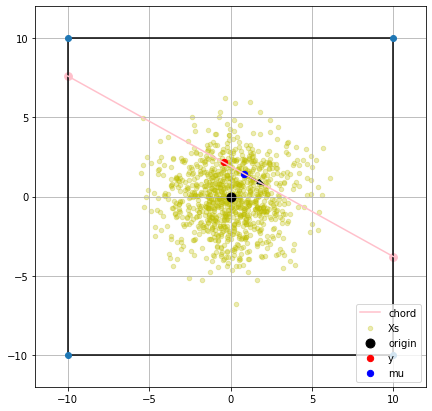

In [37]:
if d == 2:
        
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot()
    convex_hull_plot_2d(hull, ax=ax)
    interval = np.vstack([x1,x2])

    ax.plot(np.atleast_2d(interval)[:,0],np.atleast_2d(interval)[:,1],c='pink',label='chord')
    ax.scatter(np.atleast_2d(X)[:,0],np.atleast_2d(X)[:,1],s=20,c='y',alpha=0.3,label='Xs')
    ax.scatter(np.atleast_2d(origin)[:,0],np.atleast_2d(origin)[:,1],s=80,c='black',label='origin')
    ax.scatter(np.atleast_2d(y)[:,0],np.atleast_2d(y)[:,1],s=40,c='r',label='y')
    ax.scatter(np.atleast_2d(mu)[:,0],np.atleast_2d(mu)[:,1],s=40,c='b',label='mu')
    ax.scatter(np.atleast_2d(interval)[:,0],np.atleast_2d(interval)[:,1],s=60,c='pink')
    ax.arrow(mu[0],mu[1],ray[0],ray[1],head_width=0.3)
    plt.grid()
    plt.legend(loc='lower right')

Number of iterations: 20000
Number of data points: 1000
Number of Gaussian accepts: 20000
Number of Uniform accepts: 0
Henze-Zirkler multivariate normality test: True
Henze-Zirkler multivariate normality sanity test: True


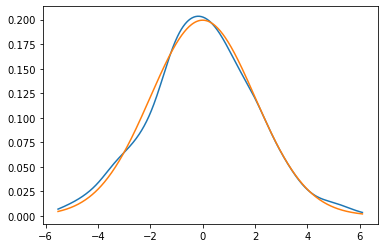

In [38]:
henze_zirkler_test = pg.multivariate_normality(X, alpha=.05)

rv = multivariate_normal(mean=origin.flatten(), cov=sigma_sq*np.eye(d))
Y = rv.rvs(size=N)
henze_zirkler_sanity = pg.multivariate_normality(Y, alpha=.05)

print('Number of iterations:',len(results))
print('Number of data points:',X.shape[0])
print('Number of Gaussian accepts:',results.accept_gaussian.sum())
print('Number of Uniform accepts:',results.accept_uniform.sum())
print('Henze-Zirkler multivariate normality test:',henze_zirkler_test.normal)
print('Henze-Zirkler multivariate normality sanity test:',henze_zirkler_sanity.normal)

linspace_num = 500
xproj = X[:,0]
xmin = xproj.min()
xmax = xproj.max()
kde = gaussian_kde(xproj)
xs = np.linspace(xmin,xmax,linspace_num)
density = kde.pdf(xs)

if d==2:

    plt.plot(xs,density)
    plt.plot(xs,norm(loc=0.,scale=sigma_sq**(0.5)).pdf(xs));

### Automated Test

Run an utomated test for the Hit & Run algorithm.

Test relies on sampling a small spherical Gaussian inside a large square. 

Normality test should return True (Cousins PhD thesis reports a 20% failure rate).

In [39]:
def hit_and_run_square_test(N: int=5000, T: int=20, sigma_sq: float=1., L: float=10.0, delta: float=0.1, linspace_num: int=500, coord_projection: int=0):
    
    points = np.array([[-L,-L],[-L,L],[L,-L],[L,L]])

    hull = ConvexHull(points,qhull_options='QJ')
    vertices = points[hull.vertices,:]
    origin = np.average(vertices,axis=0)[None,:]

    X = hit_and_run(N,origin,hull.equations,T,delta,sigma_sq=sigma_sq)
    henze_zirkler_test = pg.multivariate_normality(X, alpha=.05)

    rv = multivariate_normal(mean=origin.flatten(), cov=sigma_sq*np.eye(d))
    Y = rv.rvs(size=N)
    henze_zirkler_sanity = pg.multivariate_normality(Y, alpha=.05)

    print('Henze-Zirkler multivariate normality sample test (at least 80% success rate):',henze_zirkler_test.normal)
    print('Henze-Zirkler multivariate normality sanity test:',henze_zirkler_sanity.normal)

    xproj = X[:,coord_projection]
    xmin = xproj.min()
    xmax = xproj.max()
    kde = gaussian_kde(xproj)
    xs = np.linspace(xmin,xmax,linspace_num)
    density = kde.pdf(xs)

    plt.figure(figsize=(9,5))
    plt.plot(xs,density,label='H&R Samples')
    plt.plot(xs,norm(loc=0.,scale=sigma_sq**(0.5)).pdf(xs),label='Gaussian Samples')
    plt.title(f'Hit & Run vs. Spherical Gaussian Samples with STD {sigma_sq**(0.5)} ({N} samples projected onto the {coord_projection}-th coordinate)')
    plt.legend();

Henze-Zirkler multivariate normality sample test (at least 80% success rate): True
Henze-Zirkler multivariate normality sanity test: True


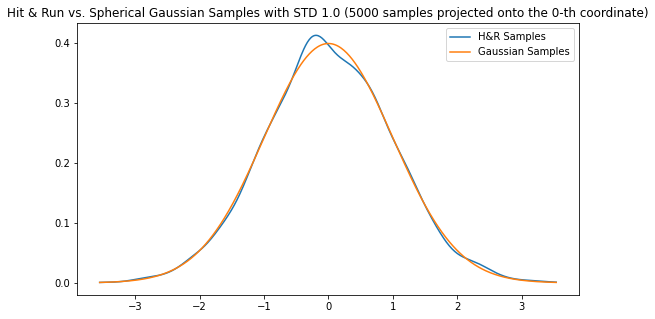

In [40]:
hit_and_run_square_test()

# Hit & Run: Polytope

A polytope is randomly generated as the convex hull of ```N``` points sampled uniformally inside a box.

## 2D

We start with $2$-dimensional polytopes.

In [41]:
box_lows = [-1,-1]
box_highs = [1,1]

assert len(box_lows)==len(box_highs), 'Box dimensions mismatch.'

d = len(box_lows)

print(f'Generating polytope in dimension: {d}')

Generating polytope in dimension: 2


Number $N$ of sampled points to generate the polytope.

In [42]:
N = 10

In [43]:
points = box_sample(box_lows,box_highs,d,N)

In [44]:
hull, vertices, simplices = get_hull(points)

Make sure the unit ball is inside the polytope by shifting and scaling.

In [45]:
cm, ratio = center_transform_coeffs(vertices, simplices)

points = (points-cm)/ratio 

hull, vertices, simplices = get_hull(points)
origin = np.average(vertices,axis=0)[None,:]

Algorithm parameters:

* ```sigma_sq```: the variance of the spherical Gaussian restricted to the polytope.
* ```delta```: the variance of the spherical Gaussian that serves as a warm start for the random walk.
* ```N```: the number of independant samples to sample.
* ```T```: the mixing time to get a single independant sample.

It is important that the warm start will be not too ambitious on the one hand, yet not too conservative. 

In [46]:
sigma_sq = 0.6
delta = 0.1
N = 2000
T = 20

In [47]:
points = (points-cm)/ratio 

hull, vertices, simplices = get_hull(points)
origin = np.average(vertices,axis=0)[None,:]

Run the algorithm used to sample spherical Gaussian or uniform samples in a polytope.

In [48]:
# X = hit_and_run(N,origin,hull,T,delta,sigma_sq=sigma_sq) # run for Gaussian distribution restricted to polytope
X = hit_and_run(N,origin,hull.equations,T,delta) # run for uniform distribution

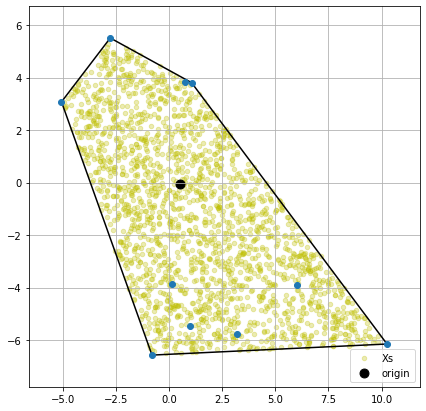

In [49]:
plot_polytope(hull, origin, X)

In [50]:
len(np.unique(X,axis=1))

2000

## 3D

We now sample from generated polytopes in 3D. Polytopes are generated in the box $B=[-1,1]^3$.

A generated polytope is the convex hull of $N$ points uniformaly sampled in the box $B$.

In [51]:
box_lows = [-1,-1,-1]
box_highs = [1,1,1]

assert len(box_lows)==len(box_highs), 'Box dimensions mismatch.'

d = len(box_lows)

print(f'Generating polytope in dimension: {d}')

Generating polytope in dimension: 3


In [52]:
N = 20

In [53]:
points = box_sample(box_lows,box_highs,d,N)

In [54]:
hull, vertices, simplices = get_hull(points)

Ensure a unit ball inside generated polytope around mean.

In [55]:
cm, ratio = center_transform_coeffs(vertices, simplices)
points = (points-cm)/ratio 
hull, vertices, simplices = get_hull(points)
mean = np.average(vertices,axis=0)[None,:]

Run the hit-and-run sampler with the following parameters.

In [56]:
sigma_sq = 0.8 # variance for spherical Gaussian
delta = 0.1 # variance for warm start sampling
N = 1000 # num data points
T = 20 # mixing time

In [57]:
X = hit_and_run(N,mean,hull.equations,T,delta,sigma_sq=sigma_sq)

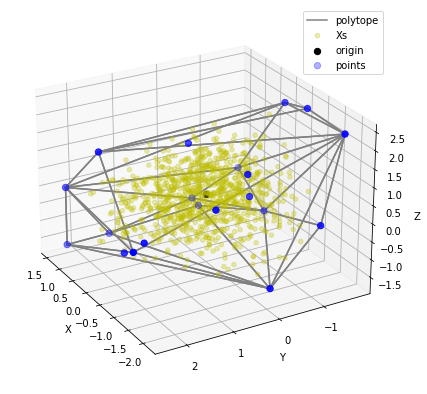

In [58]:
plot_polytope(hull, mean, X)

# Rounding

Round a convex polytope. A polytope $B_r \subseteq \Omega \subseteq B_R$ is rounder the closer $R/r$ is to 1.

Sampling a rounder convex polytope is expected to perform better.

In [59]:
def rounding(points: np.array, threshold: float=0.1, M: int=500):
    '''
    Round a convex polytope. The polytope is given as the convex hull of points.
    We assume the polytope contains a the unit ball around the origin.
    Rounding will terminate once the diff between the high and low singular values of points is below 
    the threshold times the high singular value. The lower the ratio (sval_high-sval_low)/sval_high,
    the rounder we consider the polytope to be.
    
            Parameters:
                    points (np.array): points.
                    threshold (float): stopping condition for rounding (default: 10% or 0.1).
                    M (int): terminate after M rounding attempts (default: 500).
                    
            Returns:
                    round_points: the new points after rounding.
                    T: the rounding linear transformation. Reverse-apply with round_points@la.inv(T).
                    
    '''    

    svalmax, svecmax, svalmin, svecmin = singular(points)

    T = np.eye(d)
    round_points = points
    attempts = 1

    while (svalmax-svalmin)/svalmax > threshold:
        A = tranformation(svalmax, svecmax)
        round_points, T = (A@round_points.T).T, A@T
        svalmax, svecmax, svalmin, svecmin = singular(round_points)
        if attempts>M:
            print(f'Reached max {M} rounding attempts. Rounding failed to reach the rounding threshold {threshold:.3f}.')
            break
        else:
            attempts += 1
        
    assert np.all(np.isclose((T@(points).T).T,round_points,atol=tol)), \
    'Something went wrong ... transformation T should produce rounded points from initial points.'
    
    return round_points, T

In [60]:
d = 3

In [61]:
box_lows = [-1,-1,-1]
box_highs = [1,1,1]

In [62]:
N = 10

In [63]:
points = box_sample(box_lows,box_highs,d,N)

In [64]:
hull, vertices, simplices = get_hull(points)
cm, ratio = center_transform_coeffs(vertices, simplices)

points = (points-cm)/ratio 
hull, vertices, simplices = get_hull(points)
origin = np.average(vertices,axis=0)[None,:]

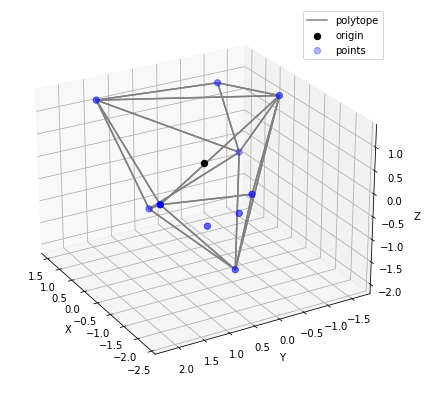

In [65]:
plot_polytope(hull, origin)

In [66]:
round_points, A = rounding(points)
round_origin = (A@origin.T).T
round_hull, _, _ = get_hull(round_points)

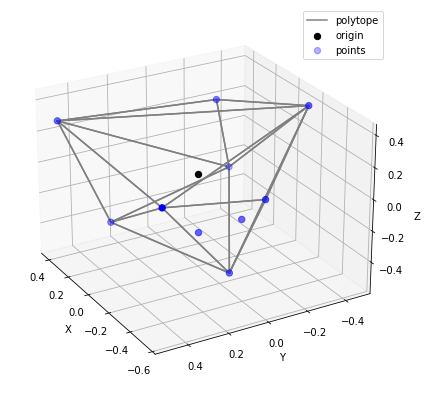

In [67]:
plot_polytope(round_hull, round_origin)

# Hit & Run: End to End

All polytopes will be generated inside the box $B=[-1,1]^d$.

In [68]:
box_lows = [-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]
box_highs = [1,1,1,1,1,1,1,1,1,1,1,1]

assert len(box_lows)==len(box_highs), 'Box dimensions mismatch.'

d = len(box_lows)

print(f'Running in dimension: {d}')

Running in dimension: 12


Sampling polytope as the convex hull of $P$ points inside the box $B$.

In [69]:
P = 25

In [70]:
points_init = box_sample(box_lows,box_highs,d,P)

In [71]:
hull_init, vertices_init, simplices_init = get_hull(points_init)
origin_init = np.average(vertices_init,axis=0)[None,:]

The number of faces of a generic polytope in $B$ increases dramatically with dimension. 

It has a dramatic impact on run time: chord computation is linear in the number of faces.

By comparison, the number of face of the box $B$ is $2d$. 

In [72]:
print('Number of faces of polytope:',simplices_init.shape[0])

Number of faces of polytope: 15924


Shift to the origin and scale to get unit ball inside.

In [73]:
shift1, scale1 = center_transform_coeffs(vertices_init, simplices_init)
points = (points_init-shift1)/scale1
origin = (origin_init-shift1)/scale1

Round the convex polytope to enable sampling.

In [74]:
points, A = rounding(points)
origin = (A@origin.T).T

Shift to the origin and scale to ensure unit ball inside again.

In [75]:
_, vertices, simplices = get_hull(points)
shift2, scale2 = center_transform_coeffs(vertices, simplices)
points = (points-shift2)/scale2
origin = (origin-shift2)/scale2

In [76]:
hull, vertices, simplices = get_hull(points)

Apply Hit & Run for sampling.

We round with a threshold $t$ (defaults to $0.1$). On the first rounding cycle, the minimal singular value goes to $1$. It remains $1$ until we hit the desired threshold. 

$$
\begin{align}
(\sigma_{\max} - \sigma_{\min}) / \sigma_{\max} & \leq t \\
(\sigma_{\max} - \sigma_{\min}) & \leq t \sigma_{\max} \\
(1-t) \sigma_{\max} & \leq \sigma_{\min} = 1 \\
\sigma_{\max} & \leq 1 / (1-t)
\end{align}
$$

We should choose $\sigma^2$ for the spherical Gaussian sampling that is congruent with the bound on $\sigma_{\max}$. By default, the bound is at $1.11$. Hence, if $\sigma^2$ goes far beyond $(1.11 \times\mbox{scale2})^2$, we'll end up with samples that look more uniform across the polytope.

In [77]:
sigma_sq = 1.
delta = 0.1
N = 1000
T = 20

In [78]:
t1 = perf_counter()
X = hit_and_run(N,origin,hull.equations,T,delta,sigma_sq=sigma_sq)
t2 = perf_counter()

In [79]:
t = strftime("%H:%M:%S",gmtime(t2-t1))
print(f"Hit & Run Convex Polytope Sampling:\nDimension: {d}\nN: {N}\nSamples: {N*T}\nVariance: {sigma_sq:.1f}\nMix Time: {T}\nTime: {t} (HH:MM:SS)")

Hit & Run Convex Polytope Sampling:
Dimension: 12
N: 1000
Samples: 20000
Variance: 1.0
Mix Time: 20
Time: 00:00:37 (HH:MM:SS)


Sampling by exclusion is unfeasible in $d>5$. We'll compare the two samples when $d \leq 5$.

In dimensions $d \leq 3$ sampling by exclusion works best.

In [80]:
if d <= 5:
    t1 = perf_counter()
    Y = warm_start(origin_init,hull_init.equations,sigma_sq,N)
    t2 = perf_counter()
    t = strftime("%H:%M:%S",gmtime(t2-t1))
    print(f"Convex Polytope Sampling by Exclusion:\nDimension: {d}\nN: {N}\nVariance: {sigma_sq:.1f}\nTime: {t} (HH:MM:SS)")

Reverse transform back to original polytope.

In [81]:
X = scale2*X+shift2
X = X@la.inv(A)
X = scale1*X+shift1

In [82]:
print('SANITY: samples inside polytope:',np.all(support(X, hull_init.equations)))
print('SANITY: number of unique samples:',np.unique(X,axis=1).shape[0])

SANITY: samples inside polytope: True
SANITY: number of unique samples: 1000


Plot samples in dimension 2 and 3.

In [83]:
plot_polytope(hull_init, origin_init, X, azimute=120)

In [84]:
if d <= 5:
    plot_polytope(hull_init, origin_init, Y, azimute=120)

timeit: Compare 

In [85]:
# %timeit -r 1 hit_and_run(N,origin,hull,T,delta,sigma_sq=sigma_sq)

In [86]:
# %timeit -r 1 warm_start(origin_init,hull_init,sigma_sq,N)

#  Profile

Profile the Hit & Run algorithm.

Profiling stats will be saved to file under ```filename```. We need ```pstats``` to read the profile stats file.

In [87]:
import profile

# profile.run('hit_and_run(N,origin,hull.hull.equations,T,delta,sigma_sq=sigma_sq)',filename='hit_and_run_profile')

In [88]:
import pstats
from pstats import SortKey

# p = pstats.Stats('hit_and_run_profile')
# p.strip_dirs().sort_stats(SortKey.CUMULATIVE).print_stats(50)

# DOFramework Integration

Integrate Hit & Run algorithm into DOFramework.

In [89]:
from doframework.core.pwl import PWL
from doframework.core.inputs import get_configs

import os
import getpass
import json
import itertools as it

import scipy.stats

In [90]:
def X_hypothesis_sampler(hypothesis, I: int, weights: list, **kwargs):
    
    while True:
        
        i = np.random.choice(np.arange(I),replace=True,p=weights)
    
        yield np.atleast_2d(hypothesis(**{k: v[i] for k,v in kwargs.items()}).rvs())

In [91]:
def X_sampler_legacy(f: PWL, hypothesis, N: int, weights: list, **kwargs):
    '''
    Sample from a mixed distribution given a hypothesis. Samples will be in Dom(f).
    This is sampling by exclusion, only fit for dimension <= 5.
    
            Parameters:
                    f (PWL): piecewise linear function.
                    hypothesis: multivariate distribution [scipy.stats].
                    N (int): sample size.
                    weights (list): weight of each distribution in the mix [adds up to 1].
                    
            Returns:
                    Sample of size N from mixed multivariate distribution defined by hypothesis and kwargs.
                    
    '''

    Is = [len(v) for v in kwargs.values()] + [len(weights)]
    
    assert min(Is) == max(Is), 'Unequal dimensions in kwargs and weights.'

    epsilon = 1e-10
    assert abs(sum(weights)-1)<epsilon, 'Weights must add up to 1.'
            
    return np.concatenate(list(it.islice(filter(lambda x: f.isin(x)[0],
                                                X_hypothesis_sampler(hypothesis,
                                                                    Is[0],
                                                                    weights,
                                                                    **kwargs)),N)))

In [92]:
def D_sampler_legacy(f: PWL, hypothesis, N: int, weights: list, noise: float, **kwargs):
    
    X = X_sampler_legacy(f,hypothesis,N,weights,**kwargs)
    y = f.evaluate(X) + norm(loc=0,scale=noise).rvs(size=X.shape[0])
    D = np.concatenate((X, y.reshape(-1,1)), 1)
    
    return D       

Get configs file.

In [93]:
configs_path = os.environ['HOME']
configs_file = 'dir_configs.yaml' # 'dir_configs.yaml', 'aws_configs.yaml', 'e2e_configs.yaml'
configs = get_configs(os.path.join(configs_path,configs_file))

user = getpass.getuser()
data_root = configs[user]['data']

Get some objective loaded from file.

In [94]:
objective_file = os.path.join(data_root,'objectives','objective_0a7zwrt9.json')
objective_file = os.path.join(data_root,'objectives','objective_0be8pf82.json')
objective_file = os.path.join(data_root,'objectives','objective_0bf6yv8f.json')
objective_file = os.path.join(data_root,'objectives','objective_0brtz1eb.json')

with open(objective_file) as file:  
    obj_input = json.load(file)

Get relevant data on objective.

In [95]:
Ps = np.array(obj_input['f']['polyhedrons'])
Vs = np.array(obj_input['f']['values'])
N = obj_input['data']['N']
noise = obj_input['data']['noise']
weights = obj_input['data']['weights']
policies = [np.array(policy) for policy in obj_input['data']['policies']]
covariances = [np.array(cov) for cov in obj_input['data']['covariances']]
data_hypothesis = obj_input['data']['hypothesis']
data_hypothesis_obj = getattr(scipy.stats,data_hypothesis)

```kwargs``` for $X$ sampling.

In [97]:
kwargs = {'mean': policies, 'cov': covariances}

Define the objective $f$.

In [98]:
f = PWL(Ps,Vs)

In [99]:
d = f.dim

assert d in [2,3], 'This test will run on objectives defined over 2 or 3 dimensional space.'

In [100]:
domain_scale = np.power(f.volume(),1/d)
print(f'f domain scale {domain_scale:.3f}')

f domain scale 5.498


The legacy sampler for comparison.

In [101]:
Y = X_sampler_legacy(f,data_hypothesis_obj,N,weights,**kwargs)

Get the number of points to sample for each Gaussian in the mix.

In [102]:
Ns = [int(w*N) for w in weights]
Ns[-1] += N-sum(Ns)

Choose a Gaussian to sample.

In [103]:
i = 2
mean = policies[i]
covariance = covariances[i]

Define the polytope within which to sample.

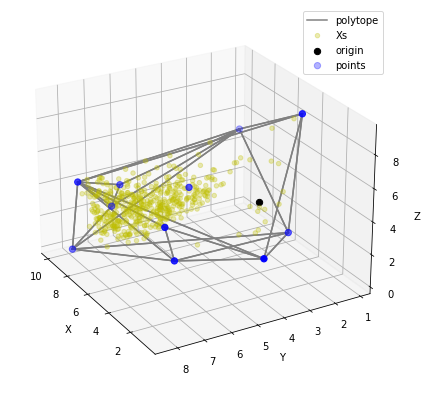

In [104]:
poly_pts = np.unique(np.vstack(Ps),axis=0)
poly_hull = ConvexHull(poly_pts)
plot_polytope(poly_hull, mean, Y)

Transform to spherical covariance.

In [105]:
u, s, uT = la.svd(covariance,full_matrices=False)
C = np.diag(s**(0.5)) @ uT # $\sqrt{\Sigma}$
Cinv = u @ np.diag(s**(-0.5))

In [106]:
assert np.all(np.isclose(C@Cinv, np.eye(d), atol=tol)), 'Root of covariance and its inverse multiply to I.'
assert np.all(np.isclose(covariance, (u @ np.diag(s**(0.5))) @ (np.diag(s**(0.5)) @ uT),atol=tol)), \
'Retrieve original covariance from SVD decomposition.'

In [107]:
print('Singular values of covariance:',s**(0.5))

Singular values of covariance: [4.95056641 2.9473052  0.42361364]


The initial points of the covariance-transformed polytope. From here on, all samples will be from a spherical gaussian.

In [108]:
points_init = poly_pts @ C
origin_init = mean @ C

In [109]:
hull_init, vertices_init, simplices_init = get_hull(points_init)

The legacy sampler with its transformed points inside the initial polytope.

In [110]:
YC = Y @ C

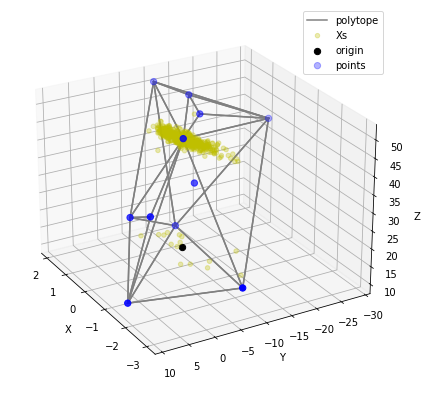

In [111]:
plot_polytope(hull_init, origin_init, YC)

Shift to mean and scale to get unit ball inside.

In [112]:
shift1 = origin_init
scale1 = scale(origin_init, simplices_init[:,0,:], hull_init.equations[:,:-1])

points = (points_init-shift1)/scale1
YCshift = (YC-shift1)/scale1
origin = (origin_init-shift1)/scale1
hull, vertices, simplices = get_hull(points)

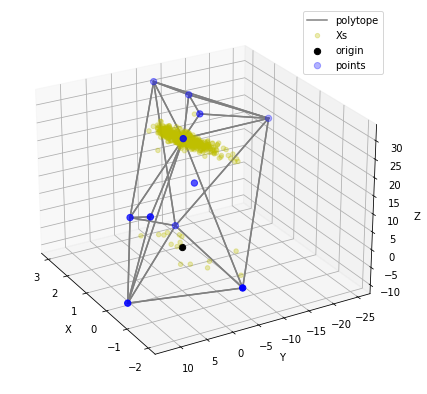

In [113]:
plot_polytope(hull, origin, YCshift)

Round the convex polytope to better enable sampling.

In [114]:
points, A = rounding(points,threshold=0.1) # comment for no rounding
# A = np.eye(d) # no rounding produces the original covariance.

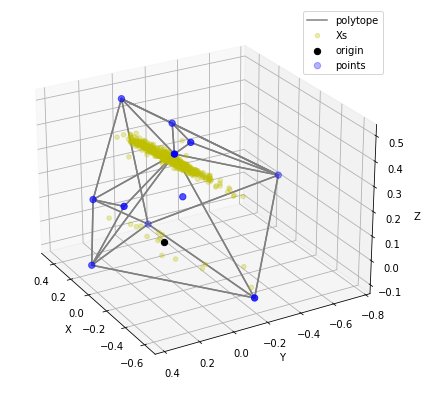

In [115]:
YCA = YCshift @ A.T # (A@YCshift.T).T
origin = (A@origin.T).T
hull, vertices, simplices = get_hull(points)
plot_polytope(hull, origin, YCA)

Shift to the origin and scale to get unit ball inside.

In [116]:
shift2 = origin
scale2 = scale(origin, simplices[:,0,:], hull.equations[:,:-1])
points = (points-shift2)/scale2
origin = (origin-shift2)/scale2
YCAshift = (YCA-shift2)/scale2

In [117]:
hull, vertices, simplices = get_hull(points)

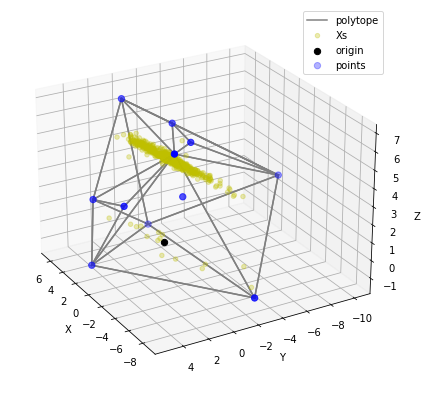

In [118]:
plot_polytope(hull, origin, YCAshift)

Choose parameters for the Hit & Run algorithm.

In [119]:
Avals = la.eigvals(A)
sigma = max(min(domain_scale,1/scale1 * gmean(Avals) * 1/scale2),1.)
sigma_sq = sigma**2
print('rounding transformation A evals:',Avals)
print('sigma:',sigma)

rounding transformation A evals: [0.35617064 0.0145122  0.04258469]
sigma: 1.0


In [120]:
delta = 0.1
T = 20

In [121]:
X = hit_and_run(Ns[i],origin,hull.equations,T,delta,sigma_sq=sigma_sq)

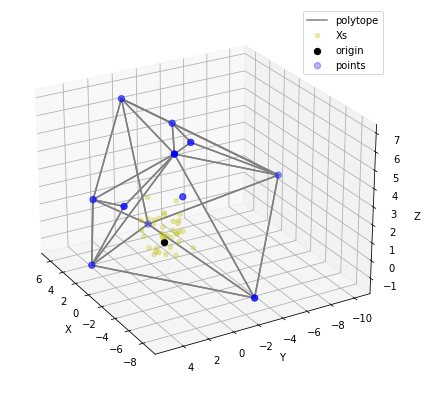

In [122]:
plot_polytope(hull, origin, X)

Reverse transform back to original polytope.

In [123]:
X = scale2*X+shift2
X = X@la.inv(A.T)
X = scale1*X+shift1

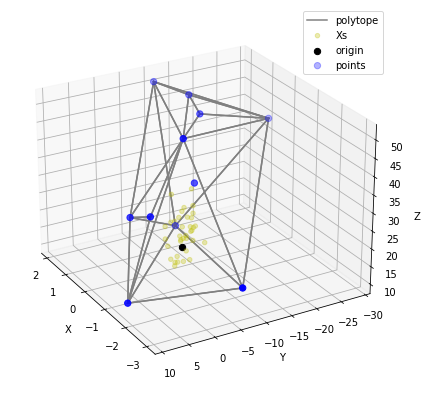

In [124]:
plot_polytope(hull_init, origin_init, X)

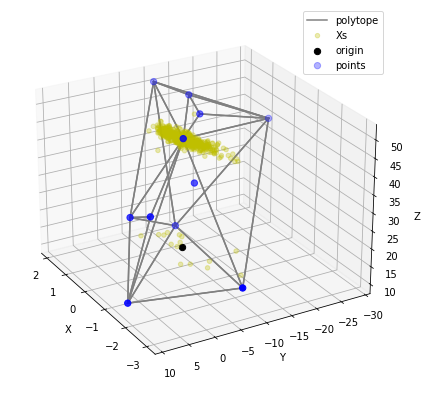

In [125]:
plot_polytope(hull_init, origin_init, scale1*((scale2*YCAshift+shift2)@la.inv(A.T))+shift1)

NOTE: We don't get the Gaussian with the given covariance! This is due to the rounding step. It does not commute with the linear transformation that makes $\Sigma$ spherical. Thus, $\Sigma$ becomes a random transformation applied to samples. The result is nevertheless a Gaussian sample. Without the rounding step, we can produce $\Sigma$-Gaussian samples. The rounding step helps the samppling in higher dimensions.

Finally, we end up with the following samples.

In [126]:
XX = X @ Cinv

In [127]:
print('SANITY: samples inside polytope:',np.all(support(XX, poly_hull.equations)))
print('SANITY: number of unique samples:',np.unique(XX,axis=1).shape[0])

SANITY: samples inside polytope: True
SANITY: number of unique samples: 37


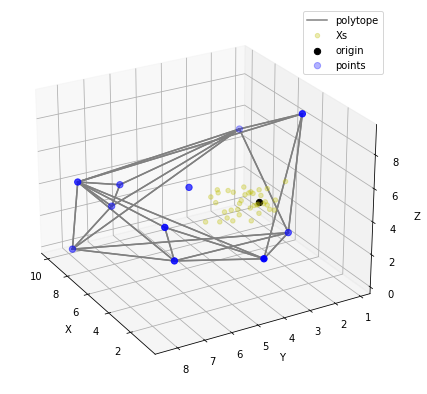

In [128]:
plot_polytope(poly_hull, mean, XX)

What we would have gotten with exclusion sampling from the given covariance:

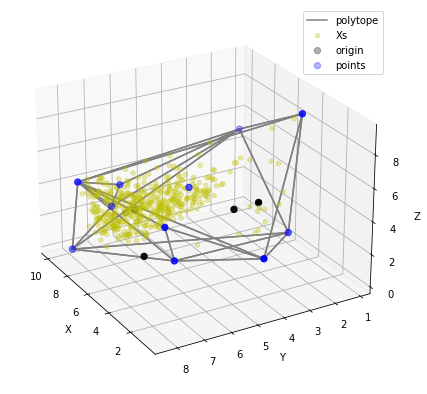

In [129]:
plot_polytope(poly_hull, np.array(policies), (scale1*((scale2*YCAshift+shift2)@la.inv(A.T))+shift1)@Cinv)

## --> Sampling End-to-End

In [130]:
def X_sampler(Ps: np.array, N: int, weights: list, **kwargs):
    '''
    Sample from a mixed Gaussian distribution restricted to a union of polytopes Ps. 
    Samples will be in the convex hull of the union of Ps.
    Sampling is done using the Hit & Run algorithm:
    -- Ben Cousins: Efficient High-dimensional Sampling and Integration.
    
            Parameters:
                    Ps (np.array): Polytopes.
                    N (int): Overall sample size.
                    weights (list): Weight of each Gaussian in the mix [must add up to 1].
                    
            Returns:
                    N samples (np.array).
                    
    '''

    means = kwargs['mean']
    covariances = kwargs['cov']
    
    # rounding the polytope
    is_round = kwargs['is_round'] if 'is_round' in kwargs else True 
    # upper bound on spherical Gaussian sigmas
    upper_bound = kwargs['upper_bound'] if 'upper_bound' in kwargs else np.inf 
    # lower bound on spherical Gaussian sigmas
    lower_bound = kwargs['lower_bound'] if 'lower_bound' in kwargs else 1.0
    # rounding threshold
    delta = kwargs['delta'] if 'delta' in kwargs else 0.1 
    # hit-and-run mix time
    T = kwargs['T'] if 'T' in kwargs else 1 
    # sensitivity 
    tol = kwargs['tol'] if 'tol' in kwargs else 1e-10 
    
    objective_id = kwargs['objective_id'] if 'objective_id' in kwargs else ''
    logger_name = kwargs['logger_name'] if 'logger_name' in kwargs else None
    is_raised = kwargs['is_raised'] if 'is_raised' in kwargs else False
    
    assert abs(sum(weights)-1)<tol, 'Weights must add up to 1.'

    lens = [len(means),len(covariances),len(weights)]    
    assert min(lens) == max(lens), 'Unequal number of policies, covariances, and weights.'    

    Ns = [int(w*N) for w in weights]
    Ns[-1] += N-sum(Ns)

    points = np.unique(np.vstack(Ps),axis=0)
    hull = ConvexHull(points)
    d = points.shape[-1]
    
    Xs = []
    sample_slice = kwargs['sample_slice'] if 'sample_slice' in kwargs else slice(0,len(Ns))

    for n, mean, covariance in zip(Ns[sample_slice], means[sample_slice], covariances[sample_slice]):

        u, s, uT = la.svd(covariance,full_matrices=False)
        B = np.diag(s**(0.5)) @ uT # square root of covariance
        Binv = u @ np.diag(s**(-0.5))
        
        assert np.all(np.isclose(B@Binv, np.eye(d), atol=tol)), 'Root of covariance and its inverse multiply to I.'
        assert np.all(np.isclose(covariance, (u @ np.diag(s**(0.5))) @ (np.diag(s**(0.5)) @ uT), atol=tol)), \
        'Retrieve original covariance from SVD decomposition.'

        points_init = points @ B
        mean_init = mean @ B
        hull_init, _, simplices_init = get_hull(points_init)
        shift_init = mean_init
        scale_init = scale(mean_init, simplices_init[:,0,:], hull_init.equations[:,:-1])

        # shift & scale for unit ball around mean inside polytope
        points_tmp = (points_init-shift_init)/scale_init
        mean_tmp = (mean_init-shift_init)/scale_init

        # round polytope. no rounding iff A = I.
        if is_round:
            points_tmp, A = rounding(points_tmp)
        else:
            A = np.eye(d)
        Ainv = la.inv(A)
        Avals = la.eigvals(A)
        
        mean_tmp = (A@mean_tmp.T).T
        hull_tmp, _, simplices_tmp = get_hull(points_tmp)

        # shift & scale for unit ball around mean inside rounded polytope
        shift_tmp = mean_tmp
        scale_tmp = scale(mean_tmp, simplices_tmp[:,0,:], hull_tmp.equations[:,:-1])
        points_tmp = (points_tmp-shift_tmp)/scale_tmp
        mean_tmp = (mean_tmp-shift_tmp)/scale_tmp

        hull_tmp, _, _ = get_hull(points_tmp)

        # when A = I, sigma_sq is scaled to produce samples from cov.
        # when A != I, produced samples are not from cov, but from A @ cov @ A^T.
        # then, sigma_sq is additionally scaled by A evals.
        sigma = max(min(upper_bound,1/scale_init * gmean(Avals) * 1/scale_tmp),lower_bound)
        sigma_sq = sigma**2

        if logger_name:
            log = logging.getLogger(logger_name)
            log.info(f'Produce {n} samples for policy {mean} with sigma {sigma:.3f}.')        
            
        X = hit_and_run(n,mean_tmp,hull_tmp.equations,T,delta,sigma_sq=sigma_sq)

        # reverse apply transformations
        X = scale_tmp*X+shift_tmp
        X = X@Ainv
        X = scale_init*X+shift_init
        X = X@Binv

        Xs.append(X)
    
    X = np.vstack(Xs)
    np.random.shuffle(X)
    
    assert np.all(support(X, hull.equations)), f'SANITY: samples not inside polytope for objective {objective_id}!'
    
    if len(Ns[sample_slice])==len(Ns):
        assert np.unique(X,axis=1).shape[0]==N, f'SANITY: {np.unique(X,axis=1).shape[0]} unique samples generated, but required {N} samples.'
    
    return X

In [131]:
def D_sampler(f: PWL, N: int, weights: list, noise: float, **kwargs): 
        
    domain_scale = np.power(f.volume(),1/f.dim)
    
    X = X_sampler(f.Ps,N,weights,upper_bound=1.2*domain_scale,lower_bound=0.2*domain_scale,**kwargs)
    y = f.evaluate(X) + norm(loc=0,scale=noise).rvs(size=X.shape[0])
    D = np.concatenate((X, y.reshape(-1,1)), 1)
    
    return D       

In [132]:
X = X_sampler(f.Ps, N, weights, mean=policies, cov=covariances, 
              is_round=True, upper_bound=1.2*domain_scale, lower_bound=0.2*domain_scale)

In [133]:
D = D_sampler(f, N, weights, noise, mean=policies, cov=covariances)

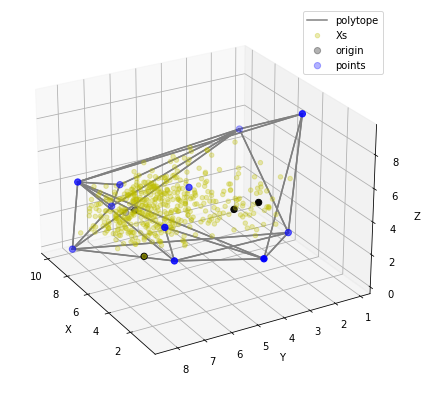

In [134]:
plot_polytope(poly_hull, np.array(policies), X=X)

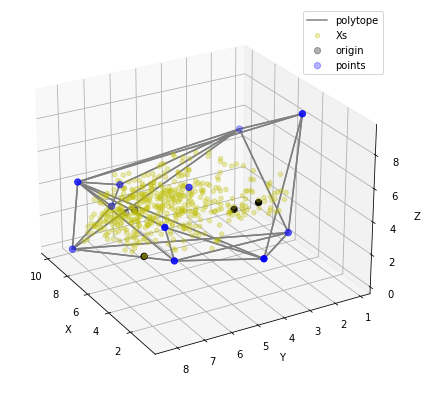

In [135]:
plot_polytope(poly_hull, np.array(policies), X=D[:,:-1])

In [136]:
for cov in covariances:
    _, s, _ = la.svd(cov)
    print('Covariance singular values geometric mean:',gmean(s**(0.5)))

Covariance singular values geometric mean: 2.5063654535659006
Covariance singular values geometric mean: 0.7389058171749218
Covariance singular values geometric mean: 1.83519963137591
Covariance singular values geometric mean: 1.1875587572091932
Covariance singular values geometric mean: 2.2502012527304878


In [137]:
print('Weights:',weights)

Weights: [0.030858223787455397, 0.888465203972253, 0.07482347217891717, 0.004432313239153385, 0.0014207868222210634]


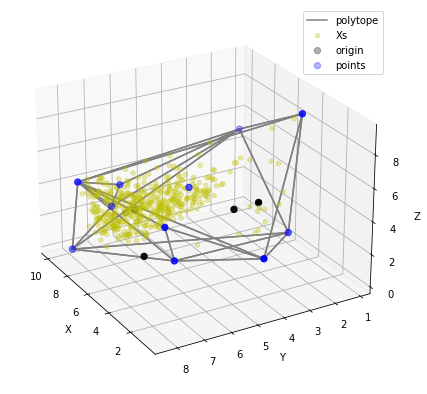

In [138]:
Ysanity = (scale1*((scale2*YCAshift+shift2)@la.inv(A.T))+shift1)@Cinv
plot_polytope(poly_hull, np.array(policies), Ysanity)